In [1]:

import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation


import os
from time import time
from tqdm import tqdm

import torch
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchinfo import summary 

In [2]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Create Dataset
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
dataset_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [4]:
dataset = ImageFolder(dataset_dir, transform=tfm)
test_ds = ImageFolder(valid_dir, transform=tfm)

In [5]:
print(dataset.class_to_idx)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [6]:
# Define the percentage of data to use for testing
validation_split = 0.2

# Calculate the length of the test split
vali_length = int(len(dataset) * validation_split)

# Calculate the length of the training split
train_length = len(dataset) - vali_length

# Split the dataset into training and test sets
train_dataset, vali_dataset = random_split(dataset, [train_length, vali_length])

# Length of Train and Test Datasets
LEN_TRAIN = len(train_dataset)
LEN_TEST = len(vali_dataset)
LEN_TEST2 = len(test_ds)

print("len of total (train) dataset {}, len of train {}, len of validation {}".format(len(dataset),len(train_dataset),len(vali_dataset)))
print("len of test dataset {}".format(len(test_ds)))

len of total (train) dataset 70295, len of train 56236, len of validation 14059
len of test dataset 17572


In [7]:
# Create data loaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
vali_loader = DataLoader(vali_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=2)

In [8]:
# Alexnet with batch norm
class AlexNet(nn.Module):
    def __init__(self, num_classes=38):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
model = AlexNet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 57,178,214 trainable parameters


In [12]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [13]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [14]:
summary(model,input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 38]                  --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 55, 55]          23,296
│    └─BatchNorm2d: 2-2                  [32, 64, 55, 55]          128
│    └─ReLU: 2-3                         [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-4                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-5                       [32, 192, 27, 27]         307,392
│    └─BatchNorm2d: 2-6                  [32, 192, 27, 27]         384
│    └─ReLU: 2-7                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-8                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 384, 13, 13]         663,936
│    └─BatchNorm2d: 2-10                 [32, 384, 13, 13]         768
│    └─ReLU: 2-11                        [32, 384, 13, 13]         -

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
model = model.to(device)
criterion = criterion.to(device)

In [17]:
optimiser = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

In [ ]:
# Lists to store the training and validation loss & accuracy for each epoch
train_losses = []
val_losses = []

train_accu = []
val_accu = []

for epoch in range(30):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            ytrain = ytrain.to(device)
            train_prob = model(xtrain)
#             train_prob = F.softmax(train_preprob, dim=-1)
            
            loss = criterion(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
        


    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in vali_loader:
            xtest = xtest.to(device)
            ytest = ytest.to(device)
            test_prob = model(xtest)
#             test_prob = F.softmax(test_preprob, dim=-1)
            
            val_loss = criterion(test_prob, ytest)
            
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    train_accu.append(ep_tr_acc)
    val_accu.append(ep_test_acc)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Validation_acc: {ep_test_acc}")

100%|██████████| 1758/1758 [04:22<00:00,  6.69batch/s]


Epoch: 0, Time: 5.402986617883046, Loss: 0.0949898287653923
Train_acc: 0.6581727007610784, Validation_acc: 0.8775161818052493


100%|██████████| 1758/1758 [03:21<00:00,  8.73batch/s]


Epoch: 1, Time: 4.1164395928382875, Loss: 0.49051833152770996
Train_acc: 0.8554840315811936, Validation_acc: 0.9207625008891102


100%|██████████| 1758/1758 [03:22<00:00,  8.66batch/s]


Epoch: 2, Time: 4.153481976191203, Loss: 1.1734341382980347
Train_acc: 0.9018600184934917, Validation_acc: 0.9194110534177395


100%|██████████| 1758/1758 [03:22<00:00,  8.70batch/s]


Epoch: 3, Time: 4.136532425880432, Loss: 0.04621843993663788
Train_acc: 0.9191621025677502, Validation_acc: 0.9560423927733125


100%|██████████| 1758/1758 [03:21<00:00,  8.70batch/s]


Epoch: 4, Time: 4.140508508682251, Loss: 0.15026690065860748
Train_acc: 0.9325876662636033, Validation_acc: 0.9591720606017498


100%|██████████| 1758/1758 [03:22<00:00,  8.66batch/s]


Epoch: 5, Time: 4.169792795181275, Loss: 0.10314754396677017
Train_acc: 0.94130094601323, Validation_acc: 0.9684188064584963


100%|██████████| 1758/1758 [03:20<00:00,  8.77batch/s]


Epoch: 6, Time: 4.12253167629242, Loss: 0.27622681856155396
Train_acc: 0.9491962443986058, Validation_acc: 0.971263959029803


100%|██████████| 1758/1758 [03:21<00:00,  8.71batch/s]


Epoch: 7, Time: 4.145319704214732, Loss: 0.39307692646980286
Train_acc: 0.9517213173056405, Validation_acc: 0.9722597624297603


100%|██████████| 1758/1758 [03:22<00:00,  8.68batch/s]


Epoch: 8, Time: 4.1587995727856955, Loss: 0.2413836270570755
Train_acc: 0.9550643715769258, Validation_acc: 0.9671384878014083


100%|██████████| 1758/1758 [03:21<00:00,  8.70batch/s]


Epoch: 9, Time: 4.144903504848481, Loss: 0.16439510881900787
Train_acc: 0.9571448893946938, Validation_acc: 0.9709794437726723


100%|██████████| 1758/1758 [03:23<00:00,  8.64batch/s]


Epoch: 10, Time: 4.172004644076029, Loss: 0.5227395296096802
Train_acc: 0.9593676648410271, Validation_acc: 0.9683476776442137


100%|██████████| 1758/1758 [03:25<00:00,  8.57batch/s]


Epoch: 11, Time: 4.210968124866485, Loss: 0.24972087144851685
Train_acc: 0.960221210612419, Validation_acc: 0.9771676506152642


100%|██████████| 1758/1758 [03:25<00:00,  8.54batch/s]


Epoch: 12, Time: 4.210434480508169, Loss: 0.02668258547782898
Train_acc: 0.9625862436873177, Validation_acc: 0.9802261896294189


100%|██████████| 1758/1758 [03:24<00:00,  8.59batch/s]


Epoch: 13, Time: 4.190064311027527, Loss: 0.5905190110206604
Train_acc: 0.9620172131730564, Validation_acc: 0.9775944235009603


100%|██████████| 1758/1758 [03:26<00:00,  8.53batch/s]


Epoch: 14, Time: 4.2091810186704, Loss: 0.16557292640209198
Train_acc: 0.965662564905043, Validation_acc: 0.9803684472579842


100%|██████████| 1758/1758 [03:25<00:00,  8.55batch/s]


Epoch: 15, Time: 4.212336111068725, Loss: 0.12196126580238342
Train_acc: 0.9669251013585604, Validation_acc: 0.970837186144107


100%|██████████| 1758/1758 [03:23<00:00,  8.63batch/s]


Epoch: 16, Time: 4.177045826117197, Loss: 0.2411113828420639
Train_acc: 0.969290134433459, Validation_acc: 0.9617326979159257


100%|██████████| 1758/1758 [03:22<00:00,  8.66batch/s]


Epoch: 17, Time: 4.157602822780609, Loss: 0.6052328944206238
Train_acc: 0.9678142115370937, Validation_acc: 0.9779500675723736


100%|██████████| 1758/1758 [03:23<00:00,  8.64batch/s]


Epoch: 18, Time: 4.166607960065206, Loss: 0.16022607684135437
Train_acc: 0.9697169073191549, Validation_acc: 0.9849918201863574


100%|██████████| 1758/1758 [03:23<00:00,  8.63batch/s]


Epoch: 19, Time: 4.16803305943807, Loss: 0.2929133474826813
Train_acc: 0.9709260971619603, Validation_acc: 0.9795149014865923


100%|██████████| 1758/1758 [03:23<00:00,  8.64batch/s]


Epoch: 20, Time: 4.171192399660746, Loss: 0.05459117889404297
Train_acc: 0.9722419802261897, Validation_acc: 0.9814353794722241


100%|██████████| 1758/1758 [03:24<00:00,  8.62batch/s]


Epoch: 21, Time: 4.200431450208028, Loss: 0.09585561603307724
Train_acc: 0.9741446760082509, Validation_acc: 0.9753894302581976


100%|██████████| 1758/1758 [03:24<00:00,  8.61batch/s]


Epoch: 22, Time: 4.173300047715505, Loss: 0.04124072939157486
Train_acc: 0.9746425777082296, Validation_acc: 0.9818621523579202


100%|██████████| 1758/1758 [03:26<00:00,  8.51batch/s]


Epoch: 23, Time: 4.2237873554229735, Loss: 0.025196120142936707
Train_acc: 0.9738423785475496, Validation_acc: 0.9844939184863788


100%|██████████| 1758/1758 [03:24<00:00,  8.60batch/s]


Epoch: 24, Time: 4.180628947416941, Loss: 0.2863010764122009
Train_acc: 0.9743580624510989, Validation_acc: 0.9860587524005975


100%|██████████| 1758/1758 [03:24<00:00,  8.61batch/s]


Epoch: 25, Time: 4.178016706307729, Loss: 0.1178540587425232
Train_acc: 0.9765630556938616, Validation_acc: 0.9787324845294829


100%|██████████| 1758/1758 [03:22<00:00,  8.66batch/s]


Epoch: 26, Time: 4.18045529127121, Loss: 0.11578449606895447
Train_acc: 0.9773454726509709, Validation_acc: 0.9780211963866562


100%|██████████| 1758/1758 [03:23<00:00,  8.65batch/s]


Epoch: 27, Time: 4.1700278679529825, Loss: 0.027500828728079796
Train_acc: 0.9761362828081656, Validation_acc: 0.9843516608578134


100%|██████████| 1758/1758 [03:24<00:00,  8.61batch/s]


Epoch: 28, Time: 4.188606798648834, Loss: 0.2433881312608719
Train_acc: 0.9789103065651895, Validation_acc: 0.9870545558005548


100%|██████████| 1758/1758 [03:24<00:00,  8.61batch/s]


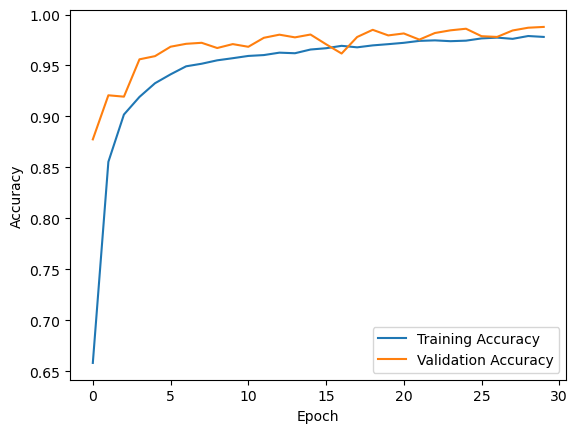

In [20]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_accu, label='Training Accuracy')
plt.plot(val_accu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


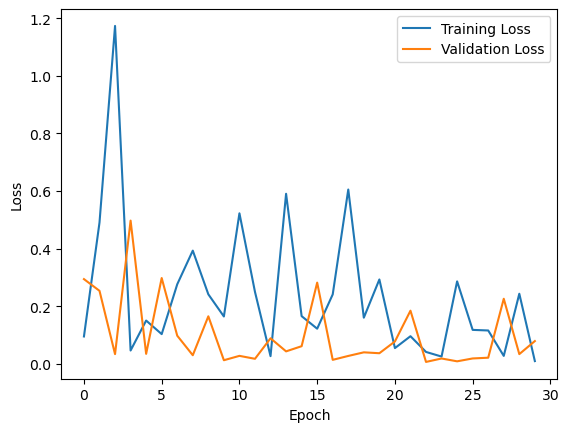

In [21]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimiser.state_dict()}

torch.save(checkpoint, 'alnet30e.pth')

In [22]:
test_acc = 0
model.eval()
with torch.no_grad():
    for xtest, ytest in test_loader:
        xtest = xtest.to(device)
        test_prob = model(xtest)
        test_prob = test_prob.cpu()

        test_pred = torch.max(test_prob,1).indices
        test_acc += int(torch.sum(test_pred == ytest))

    ep_test_acc = test_acc / LEN_TEST2
print("test dataset accuracy: {}".format(ep_test_acc))

test dataset accuracy: 0.9883906214432051


In [25]:
# Image Samples
sample_1 = '../input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG'
sample_2 = '../input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG'
sample_3 = '../input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight4.JPG'
sample_4 = '../input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus2.JPG'

sample_list = [sample_1,sample_2,sample_3,sample_4]

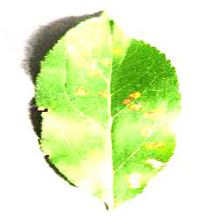

Apple___Cedar_apple_rust


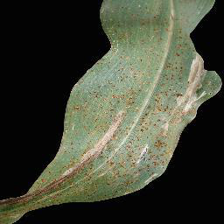

Corn_(maize)___Common_rust_


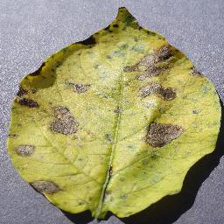

Potato___Early_blight


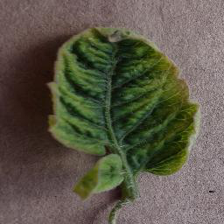

Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [26]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    kv = dataset.class_to_idx
    li = [k for k,v in kv.items() if v == pred]
    print(*li)
